In [1]:
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from IPython.display import clear_output

def min_max_norm(x):
    mx = np.min(x)
    return (x - mx)/(np.max(x)-mx)

def std_norm(x):
    return (x - np.mean(x))/np.std(x)

In [6]:
test_data = pd.read_csv(filepath_or_buffer='test.csv', na_values=["?"])
test_data_IDs = test_data.loc[:, "Id"]
test_data = test_data.drop("Id", axis=1)
test_cat_features_mask = (test_data.dtypes == "object").values
normalizer = preprocessing.StandardScaler()
test_X_real = test_data[test_data.columns[~test_cat_features_mask]]
mis_replacer = KNNImputer(n_neighbors=5, weights='distance')
test_X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(test_X_real), columns=test_X_real.columns)
test_X_no_mis_norm = normalizer.fit_transform(test_X_no_mis_real)
test_X_cat = test_data[test_data.columns[test_cat_features_mask]].fillna("")

dataset = pd.read_csv(filepath_or_buffer='train.csv', na_values=["?"]).drop("Id", axis=1)
data = dataset.drop('SalePrice', axis=1)
target = dataset.values[:, -1].astype(np.float)
cat_features_mask = (data.dtypes == "object").values
normalizer = preprocessing.StandardScaler()
X_real = data[data.columns[~cat_features_mask]]
mis_replacer = KNNImputer(n_neighbors=5, weights='distance')
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
X_no_mis_norm = normalizer.fit_transform(X_no_mis_real)
X_cat = data[data.columns[cat_features_mask]].fillna("")

X_cat_one_hot = pd.get_dummies(pd.concat((X_cat, test_X_cat), axis = 0), drop_first=True).values[:len(X_cat)]

target_norm = std_norm(target)

X = np.concatenate([X_no_mis_norm, X_cat_one_hot], axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.1)
test_X_cat_one_hot_whole_pack = pd.get_dummies(pd.concat((test_X_cat, X_cat), axis = 0), drop_first=True)
test_X_cat_one_hot = test_X_cat_one_hot_whole_pack.values[:len(test_X_cat)]
test_X = np.concatenate([test_X_no_mis_norm, test_X_cat_one_hot], axis=1)
test_X_frame = pd.DataFrame(data=test_X, columns=test_X_no_mis_real.columns.append(test_X_cat_one_hot_whole_pack.columns))
# print(test_X_no_mis_real.columns.append(test_X_cat_one_hot_whole_pack.columns))

### kNN

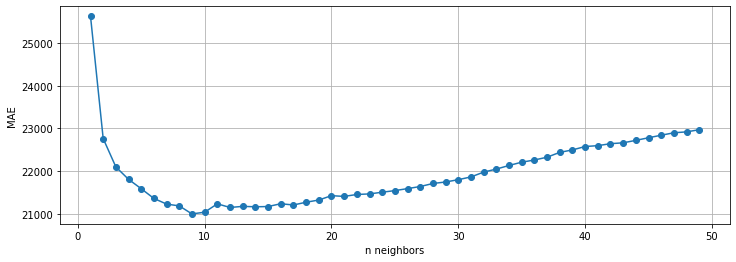

In [7]:
res = []
n_neighs = range(1, 50)
for n_neigh in n_neighs:
    print('current n_neigh: ' + str(n_neigh))
    model = KNeighborsRegressor(n_neighbors=n_neigh, weights='distance', algorithm='auto')
    res.append(-cross_val_score(model, X, target, scoring='neg_mean_absolute_error', n_jobs=3, cv=10).mean())
    clear_output(True)

clear_output(True)

plt.figure(figsize=[12, 4])
plt.plot(n_neighs, res, marker='o')
plt.xlabel('n neighbors')
plt.ylabel('MAE')
plt.grid()
plt.show()

In [8]:
print('optimal n_neighbors: ' + str(n_neighs[np.argmin(res)]))
print('MAE with optimal n_neighbors: ' + str(np.min(res)))

optimal n_neighbors: 9
MAE with optimal n_neighbors: 20995.738368821425


### Decision Tree

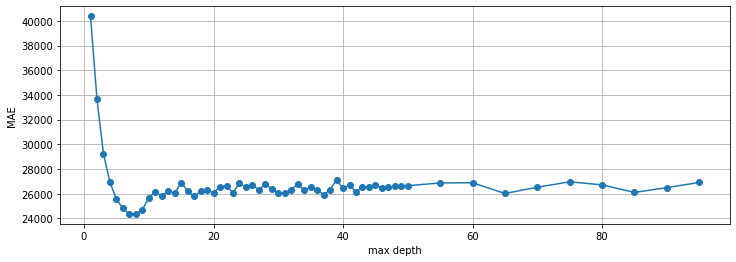

In [9]:
res = []
depths = np.arange(1, 50)
depths = np.concatenate((depths, np.arange(50, 100, 5)), axis=0)
for depth in depths:
    print('current max depth: ' + str(depth))
    model = DecisionTreeRegressor(criterion='mae', max_depth=depth)
    res.append(-cross_val_score(model, X, target, scoring='neg_mean_absolute_error', n_jobs=4, cv=10).mean())
    clear_output(True)

plt.figure(figsize=[12, 4])
plt.plot(depths, res, marker='o')
plt.xlabel('max depth')
plt.ylabel('MAE')
plt.grid()
plt.show()

In [10]:
print('optimal max depth: ' + str(depths[np.argmin(res)]))
print('MAE with optimal max depth: ' + str(np.min(res)))

optimal max depth: 8
MAE with optimal max depth: 24363.643835616436


### Random Forest

In [3]:
res = []
# depths = np.arange(1, 10)
n_ests = np.arange(5, 100, 5)
n_ests = np.concatenate((n_ests, np.arange(100, 500, 20)), axis=0)
for n_est in n_ests:
    print('current n_est: ' + str(n_est))
    model = RandomForestRegressor(n_estimators=n_est, criterion='mae', oob_score=True, bootstrap=True, n_jobs=4)
    res.append(-cross_val_score(model, X, target, scoring='neg_mean_absolute_error', n_jobs=4, cv=10).mean())
    clear_output(True)


current n_est: 480


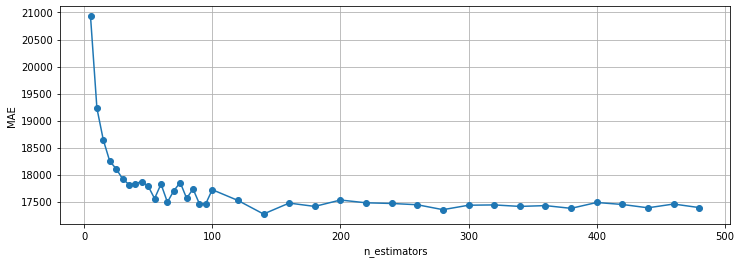

In [4]:
plt.figure(figsize=[12, 4])
plt.plot(n_ests, res, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.grid()
plt.show()

In [5]:
print('optimal n_estimators: ' + str(n_ests[np.argmin(res)]))
print('MAE with optimal n_estimators: ' + str(np.min(res)))

optimal n_estimators: 140
MAE with optimal n_estimators: 17271.017879158513


### Gradient Boosting

In [5]:
ress = []
depths = np.arange(1, 11)
num_steps = 28
steps = np.linspace(5, 150, num_steps)
steps = steps.astype(dtype=np.int)
n_ests = [np.sum(steps[:i]) for i in range(1, num_steps)]
print(n_ests[-1])

2007


In [6]:
for depth in depths:
    res = []
    for n_est in n_ests:
        print('current max depth: ' + str(depth))
        print('current n_est: ' + str(n_est))
        model = GradientBoostingRegressor(n_estimators=n_est, max_depth=depth, min_samples_split=5, learning_rate=0.01)
        res.append(-cross_val_score(model, X, target, scoring='neg_mean_absolute_error', n_jobs=4, cv=10).mean())
        clear_output(True)
    ress.append(res)

current max depth: 10
current n_est: 2007


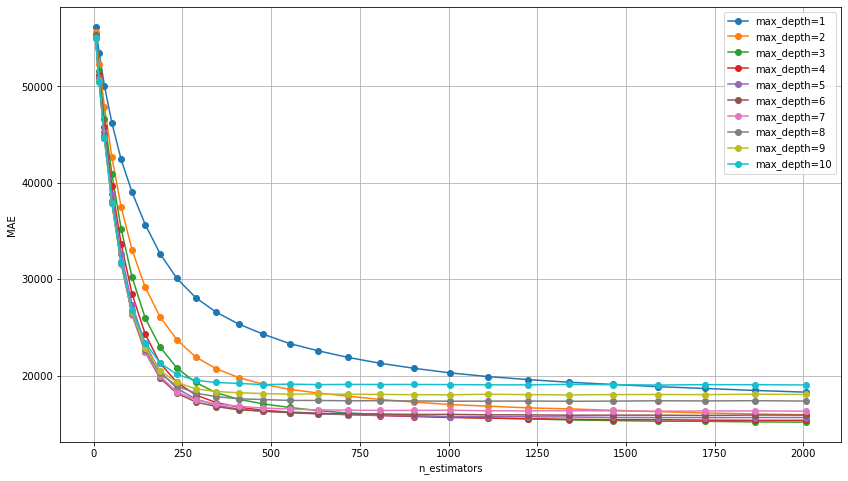

In [10]:
plt.figure(figsize=[14, 8])
for res, depth in zip(ress, depths):
    plt.plot(n_ests, res, marker='o', label='max_depth='+str(depth))

plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.grid()
plt.legend()
plt.show()

In [33]:
ress_np = np.stack(ress, axis=0)
print('optimal estimator depth: ' + str(depths[int(np.argmin(ress_np)/27)]))
print('optimal number of estimators: ' + str(n_ests[np.argmin(ress_np)%27]))
print('MAE with optimal parameters: ' + str(np.min(ress_np)))

optimal estimator depth: 3
optimal number of estimators: 2007
MAE with optimal parameters: 15187.430991341875


In [10]:
model = GradientBoostingRegressor(n_estimators=3000, max_depth=3, min_samples_split=5, learning_rate=0.01)
print(-cross_val_score(model, X, target, scoring='neg_mean_absolute_error', n_jobs=4, cv=10).mean())
model.fit(X, target)

15035.443493819732


GradientBoostingRegressor(learning_rate=0.01, min_samples_split=5,
                          n_estimators=3000)

In [8]:
result = model.predict(test_X)
result = pd.DataFrame(data=np.stack((test_data_IDs, result), axis=1).astype(dtype=np.int), columns=["Id", "SalePrice"])
result.to_csv('result.csv', index=False)

### SHAP



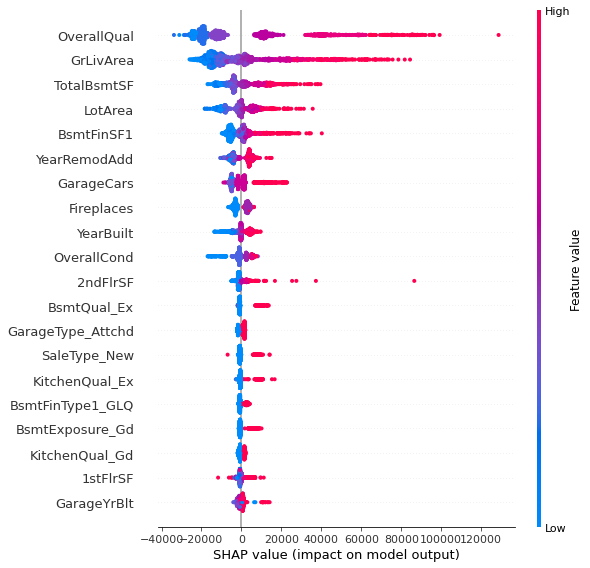

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X_frame)
# print(test_X_frame.columns)
shap.summary_plot(shap_values, test_X_frame)